# NGP retreat talk
consolidated figures for the NGP presentation
a lot of these figures are inherited from the DAC4 presentation

the main aditions is the 10 sound dataset anaalysis

In [1]:
from pathlib import Path
import itertools as itt

import joblib as jl
import pathlib as pl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import pandas as pd
import seaborn as sns
from IPython.display import display
from statannot import add_stat_annotation
from cycler import cycler

from src.data.region_map import region_map
from src.visualization.fancy_plots import savefig
from src.metrics.consolidated_dprimes import _load_site_formated_raste, single_cell_dprimes, full_dPCA_dprimes, probewise_dPCA_dprimes
from src.data.dPCA import _cpp_dPCA, format_raster
from src.visualization.fancy_plots import _raster, unit_line
from src.metrics.significance import _significance
from src.metrics.dprime import flip_dprimes
from src.metrics.reliability import signal_reliability
from src.data.rasters import raster_from_sig
from src.data.load import load_with_parms
from src.root_path import root_path, config_path
from configparser import ConfigParser


[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-09-13 091920.log
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:66: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:76: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:81: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}


importing region_map: site ley058d has undefined region


[numexpr.utils INFO] NumExpr defaulting to 8 threads.


In [3]:
config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

In [4]:
#general plottin formating
plt.style.use(['dark_background', config_path / 'notebook.mplstyle'])


In [4]:
# 4 sound file
DF4_file = pl.Path(config['paths']['analysis_cache']) /'210302_consolidated_summary_DF_alpha_0.05/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'
DF4 = jl.load(DF4_file)

# 10 soundfile
DF10_file = pl.Path(config['paths']['analysis_cache']) /'210902_consolidated_summary_DF_alpha_0.05/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_stim_type-permutations_zscore-True'

DF10 = jl.load(DF10_file)

In [43]:
mult_comp_cont = 4
# pulls DF, removes unused columns and data, refactor redunant id columns and create probe_id
def format_dataframe(DF):
    ff_probe = DF.probe != 'mean'
    ff_pairs = DF.context_pair != 'mean'
    try:
        ff_mean = DF.mean_signif_type == 'shuffles'
    except:
        print('no mean_signif_type, taking all values')
        ff_mean = pd.Series(np.full(DF.shape[0], True))


    try:
        ff_stim = DF.stim_type == 'permutations'
    except:
        print('no stim_type, taking all values')
        ff_stim = pd.Series(np.full(DF.shape[0], True))


    ff_analylis = DF.analysis.isin(['SC', 'fdPCA'])
    # ff_corr = DF.mult_comp_corr == 'consecutive_3'
    ff_corr = DF.mult_comp_corr == f'consecutive_{mult_comp_cont}'
    ff_metric = DF.metric.isin(['significant_abs_mass_center', 'significant_abs_sum'])

    good_cols =['analysis', 'mult_comp_corr', 'region', 'siteid',  'cellid', 'context_pair',
                'probe', 'metric', 'value']
    filtered = DF.loc[ff_stim & ff_mean & ff_pairs & ff_probe & ff_analylis & ff_corr & ff_metric, good_cols]

    filtered['probe'] = [int(p) for p in filtered['probe']]
    filtered['context_pair'] = [f"{int(cp.split('_')[0]):02d}_{int(cp.split('_')[1]):02d}"
                                for cp in filtered['context_pair']]

    # rename metrics and analysis for ease of ploting
    filtered['metric'] = filtered['metric'].replace({'significant_abs_mass_center': 'center of mass (ms)',
                                                     'significant_abs_mean': "mean d'",
                                                     'significant_abs_sum': "integral (d'*ms)"})
    filtered['analysis'] = filtered['analysis'].replace({'SC': 'single cell',
                                                         'fdPCA': 'population',
                                                         'pdPCA': 'probewise pop',
                                                         'LDA': 'pop ceiling'})

    filtered['id'] = filtered['cellid'].fillna(value=filtered['siteid'])
    filtered = filtered.drop(columns=['cellid', 'siteid'])

    filtered['value'] = filtered['value'].fillna(value=0)

    # permutation related preprocesing.
    # creates a new column relating probe with  context pairs
    ctx = np.asarray([row.split('_') for row in filtered.context_pair], dtype=int)
    prb = np.asarray(filtered.probe, dtype=int)

    silence = ctx == 0
    same = ctx == prb[:,None]
    different = np.logical_and(~silence, ~same)

    name_arr = np.full_like(ctx, np.nan, dtype=object)
    name_arr[silence] = 'silence'
    name_arr[same] = 'same'
    name_arr[different] = 'diff'
    comp_name_arr = np.apply_along_axis('_'.join, 1, name_arr)

    # swaps clasification names to not have repetitions i.e. diff_same == same_diff
    comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'
    comp_name_arr[np.where(comp_name_arr == 'diff_silence')] = 'silence_diff'
    comp_name_arr[np.where(comp_name_arr == 'diff_same')] = 'same_diff'
    comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'

    filtered['trans_pair'] = comp_name_arr

    ord_cols = ['analysis', 'region', 'id', 'context_pair', 'trans_pair', 'probe', 'metric', 'value']
    pivot_idx = [col for col in ord_cols if col not in ['value', 'metric']]
    pivoted = filtered.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc='first').reset_index()

    full_long = filtered # saves long format for subsamplig analysis

    return pivoted, full_long
pivoted, full_long = pd.DataFrame(), pd.DataFrame()
for df in [DF4, DF10]:
    pvtd, fl_lg = format_dataframe(df)
    pivoted = pivoted.append(pvtd)
    full_long = full_long.append(fl_lg)

del(fl_lg, pvtd)

no mean_signif_type, taking all values
no stim_type, taking all values


In [6]:
display(full_long)

,analysis,mult_comp_corr,region,context_pair,probe,metric,value,id,trans_pair
75735,single cell,consecutive_4,PEG,00_01,1,center of mass (ms),0.0,AMT028b-01-1,silence_same
75736,single cell,consecutive_4,PEG,00_01,1,center of mass (ms),0.0,AMT028b-01-2,silence_same
75737,single cell,consecutive_4,PEG,00_01,1,center of mass (ms),0.0,AMT028b-04-1,silence_same
75738,single cell,consecutive_4,PEG,00_01,1,center of mass (ms),0.0,AMT028b-06-1,silence_same
75739,single cell,consecutive_4,PEG,00_01,1,center of mass (ms),0.0,AMT028b-07-1,silence_same
...,...,...,...,...,...,...,...,...,...
854695,population,consecutive_4,A1,07_09,10,integral (d'*ms),0.0,TNC015a,diff_diff
854696,population,consecutive_4,A1,07_10,10,integral (d'*ms),0.0,TNC015a,same_diff
854697,population,consecutive_4,A1,08_09,10,integral (d'*ms),0.0,TNC015a,diff_diff
854698,population,consecutive_4,A1,08_10,10,integral (d'*ms),0.0,TNC015a,same_diff


In [7]:
# counts the total number of values for each comparison (SC, fDPCA) x (sile_diff, sile_same, diff_diff, same_diff)
# counts the proportion of signifciant vs non singificant(zero-zero) values
# decimates the more numerous comparisons??

# set the array to group by id, context_pair, and probe. Keeping analysis, region and transision_pair
# the final array should have analysis, region and trans pair as rowns, and total count, and significants as columns

def nozero_mean(arr):
    arr[arr==0] = np.nan
    return np.nanmean(arr)

def nozero_count(arr):
    return np.sum(arr>0)

def nozero_proportion(arr):
    return np.sum(arr>0) / np.size(arr)

def nozero_percentage(arr):
    return np.sum(arr>0) / np.size(arr) *100

filtered = full_long
group_ready = pivoted.set_index(['analysis', 'region', 'trans_pair']).loc[:, filtered.metric.unique()]
agg_funcs = {'center of mass (ms)': [('mean duration', nozero_mean)],
             "integral (d'*ms)": [('mean amplitude', nozero_mean),
                                     ('total', 'size'),
                                     ('n_signif', nozero_count)]}

grouped = group_ready.groupby(['analysis', 'region', 'trans_pair']).agg(agg_funcs)
grouped.columns = grouped.columns.droplevel(0)
grouped['significant %'] = grouped.n_signif / grouped.total * 100

## count number of cells or sites with significant contextual effects

In [18]:
# analyses = ['single cell', 'population', 'probewise pop', 'pop ceiling'] # 4 sounds
analyses = ['single cell', 'population'] # 10 sounds

for analysis in analyses:
    all_id_df= pivoted.loc[pivoted.analysis == analysis, ['id']]
    all_id_count = len(all_id_df.id.unique())

    good_id_df= pivoted.loc[(pivoted.analysis == analysis) & (pivoted["integral (d'*ms)"] > 0), ['id']]
    good_id_count = len(good_id_df.id.unique())

    print(f'{analysis}\n{good_id_count} of {all_id_count}. {good_id_count/all_id_count*100:.2f}%')

single cell
818 of 1109. 73.76%
population
41 of 41. 100.00%


## how many contextual instances per site/cell and on average

In [19]:
goodcount = pivoted.set_index(['analysis', 'id']).loc[:,["integral (d'*ms)"]]
agg_funcs = {"integral (d'*ms)": [('all',np.size),
                                  ('good', nozero_count)]}
goodcount = goodcount.groupby(['analysis','id']).agg(agg_funcs)
goodcount.columns = goodcount.columns.droplevel(0)
goodcount = goodcount.loc[goodcount['good'] > 0]
goodcount['percent'] = goodcount['good'] / goodcount['all'] * 100
# display(goodcount)

for analysis in analyses:
    arr = goodcount.loc[(analysis), 'percent'].values
    print(f'{analysis}\n{np.mean(arr):.2f}% significant instances on average')

single cell
13.62% significant instances on average
population
47.24% significant instances on average


## count of significant instances
### single cell

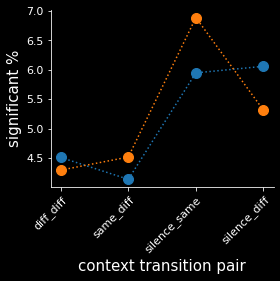

In [20]:
analysis = 'single cell'
value = 'significant %'

fig, ax = plt.subplots()

toplot = grouped.loc[(analysis), (value)]
toplot = toplot.reset_index()
toplot = toplot.pivot(values=value, columns='region', index='trans_pair')
toplot = toplot.reindex(index=['diff_diff', 'same_diff', 'silence_same', 'silence_diff'])

_ = ax.plot(toplot.A1, color='C0', linestyle=':', label='A1')
_ = ax.scatter(range(4), toplot.A1, color='C0', s=100)
try:
    _ = ax.plot(toplot.PEG, color='C1', linestyle=':', label='PEG')
    _ = ax.scatter(range(4), toplot.PEG, color='C1', s=100)
except:
    print('no PEG sites')


plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_ylabel('significant %')
ax.set_xlabel('context transition pair')
fig.set_size_inches(4,4)
title = 'single_cell_signif_percent_plot'
# savefig(fig, 'NGP_retreat', title)

### population

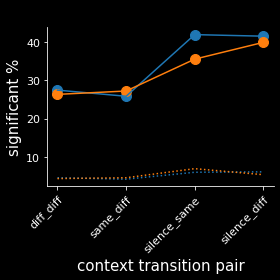

In [21]:
# for the population plots both single cell and population

# # 4 sounds  and PEG
# analyses = ['population', 'probewise pop', 'pop ceiling']
# linestyles = ['-', '--', '-.']

# 10 sound no PEG
analyses = ['population']
linestyles = ['-']



for analysis, linestyle in zip(analyses, linestyles):
    fig, ax = plt.subplots()

    value = 'significant %'

    toplot = grouped.loc[('single cell'), (value)]
    toplot = toplot.reset_index()
    toplot = toplot.pivot(values=value, columns='region', index='trans_pair')
    toplot = toplot.reindex(index=['diff_diff', 'same_diff', 'silence_same', 'silence_diff'])

    _ = ax.plot(toplot.A1, color='C0', linestyle=':', label=f'single cell A1')
    try:
        _ = ax.plot(toplot.PEG, color='C1', linestyle=':', label=f'single cell PEG')
    except:
        print('no PEG sites')

    # population
    toplot = grouped.loc[(analysis), (value)]
    toplot = toplot.reset_index()
    toplot = toplot.pivot(values=value, columns='region', index='trans_pair')
    toplot = toplot.reindex(index=['diff_diff', 'same_diff', 'silence_same', 'silence_diff'])

    _ = ax.plot(toplot.A1, color='C0', linestyle=linestyle, label=f'{analysis} A1')
    _ = ax.scatter(range(4), toplot.A1, color='C0', s=100)
    try:
        _ = ax.plot(toplot.PEG, color='C1', linestyle=linestyle, label=f'{analysis} PEG')
        _ = ax.scatter(range(4), toplot.PEG, color='C1', s=100)
    except:
        print('no PEG sites')

    # format ax labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set_ylabel('significant %')
    ax.set_xlabel('context transition pair')

    ax.set_title(' ')
    fig.set_size_inches(4,4)

    title = f'{analysis}_signif_percent_plot'
    # savefig(fig, 'NGP_retreat', title)

In [8]:
trans_ord = ['diff_diff', 'same_diff', 'silence_same', 'silence_diff']
reg_ord = ['A1', 'PEG']
ana_ord = ['single cell', 'population']

In [9]:
# grid with proportion anotations
def anotated_nozero_scatter(x, y, **kws):

    total = x.shape[0]
    x = x[x>0]
    y = y[y>0]
    fontsize = kws.pop('fontsize', 12)
    n_signif = len(x)
    percent_good = n_signif / total * 100

    ax = plt.gca()
    ax.scatter(x, y, s=8, alpha=0.1, **kws)
    sns.kdeplot(x=x, y=y, ax=ax,**kws)
    ax.set_xlim(0,ax.get_xlim()[1])
    ax.set_ylim(0,ax.get_ylim()[1])

    ax.text(.5, 0.5, f'n {total}\n{percent_good:.2f}% signif', fontsize=fontsize, transform=ax.transAxes, **kws)


# plots showing the progression of the date split
## single cell

saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/single_cell_parameter_space_pooled.png


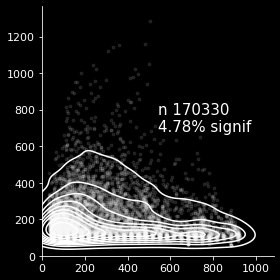

In [30]:
scDF = pivoted.loc[pivoted.analysis == 'single cell',:]

g = sns.FacetGrid(data=scDF, row=None, col=None, hue=None,
                  sharex=True, sharey=True, legend_out=True,
                  row_order=ana_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)', "integral (d'*ms)", color='white', fontsize=15)
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
# g.set_axis_labels("duration of contextual\ndiscrimination (ms)",
#                   "magnitude of contextual\ndiscrimination (d' * ms)")
g.set_axis_labels("",
                  "")
fig = g.fig
fig.set_size_inches(4, 4)

title = 'single_cell_parameter_space_pooled'
savefig(fig, 'NGP_retreat', title)

saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/single_cell_parameter_space_transitions.png


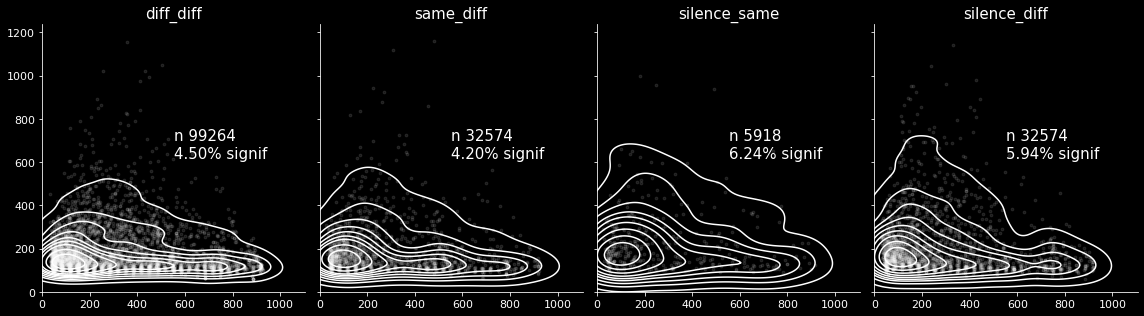

In [31]:
scDF = pivoted.loc[pivoted.analysis == 'single cell',:]
g = sns.FacetGrid(data=scDF, row=None, col='trans_pair', hue=None,
                  sharex=True, sharey=True, legend_out=True,
                  row_order=ana_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)', "integral (d'*ms)", color='white', fontsize=15)
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="", col_template="{col_name}")
g.set_axis_labels("",
                  "")
fig = g.fig
fig.set_size_inches(16,4.5)

title = 'single_cell_parameter_space_transitions'
savefig(fig, 'NGP_retreat', title)

saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/single_cell_parameter_space_trans_region.png


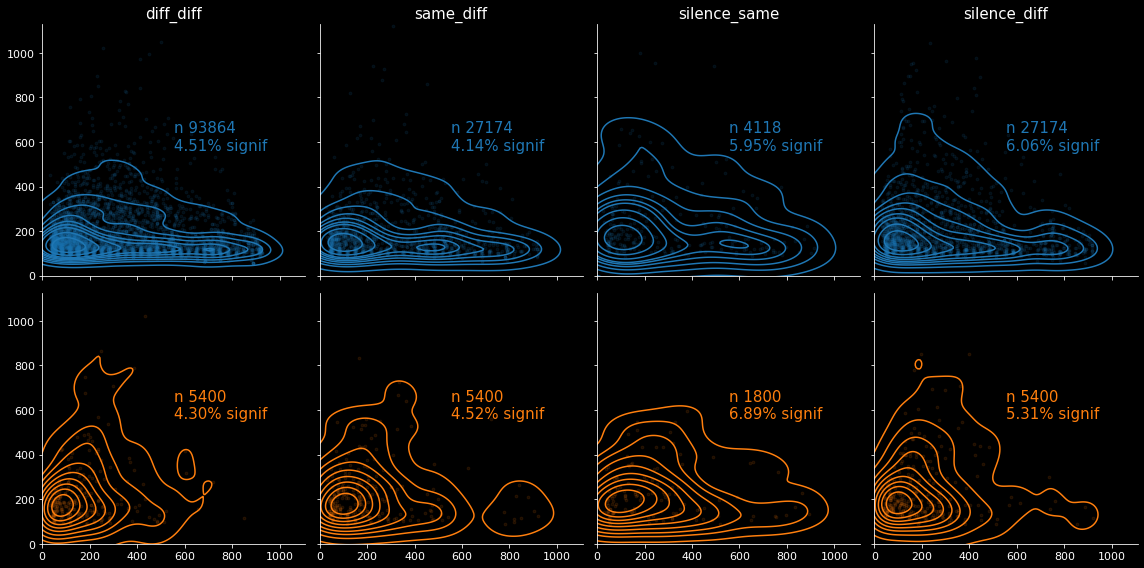

In [32]:
scDF = pivoted.loc[pivoted.analysis == 'single cell',:]
g = sns.FacetGrid(data=scDF, row='region', col='trans_pair', hue='region',
                  sharex=True, sharey=True, legend_out=True,
                  row_order=reg_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)', "integral (d'*ms)", fontsize=15)
g.set_titles(template="")
# g.set_axis_labels("duration of contextual\ndiscrimination (ms)",
#                   "magnitude of contextual\ndiscrimination (d' * ms)")
g.set_axis_labels("",
                  "")
g._margin_titles = True
g.set_titles(row_template="", col_template="{col_name}")
fig = g.fig
fig.set_size_inches(16,8)

title = 'single_cell_parameter_space_trans_region'
savefig(fig, 'NGP_retreat', title)

## Population

population
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/population_parameter_space_trans_region.png


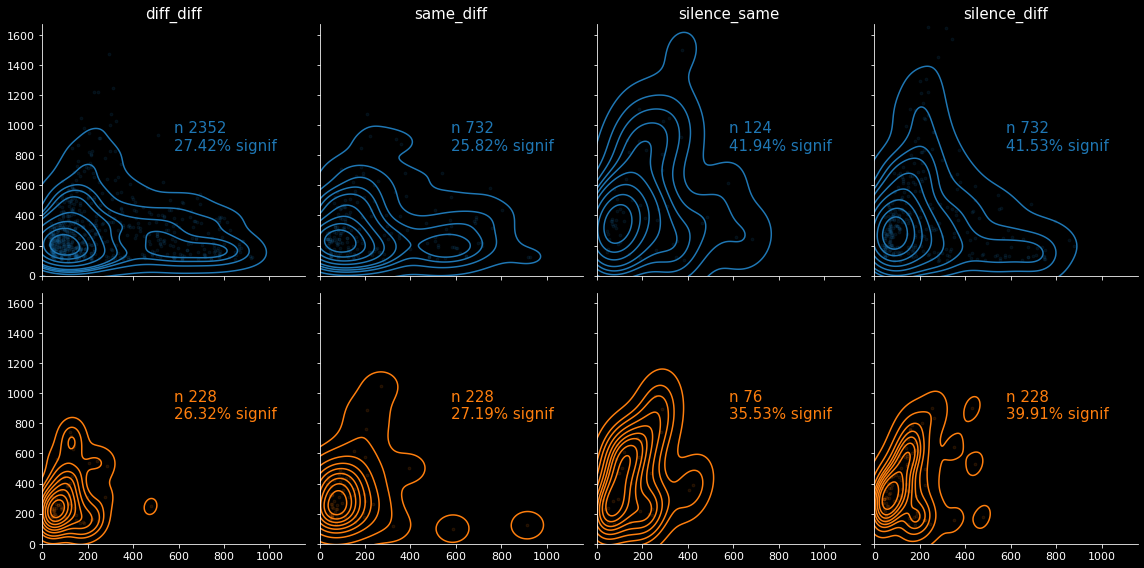

In [33]:
# analyses = ['population', 'probewise pop', 'pop ceiling']
analyses = ['population']
for analysis in analyses:
    print(analysis)
    scDF = pivoted.loc[pivoted.analysis == analysis,:]
    g = sns.FacetGrid(data=scDF, row='region', col='trans_pair', hue='region',
                      sharex=True, sharey=True, legend_out=True,
                      row_order=reg_ord, col_order=trans_ord, hue_order=reg_ord)
    g.map(anotated_nozero_scatter, 'center of mass (ms)',  "integral (d'*ms)", fontsize=15)
    g.set_titles(template="")
    g.set_axis_labels("",
                      "")
    g._margin_titles = True
    g.set_titles(row_template="", col_template="{col_name}")
    fig = g.fig
    fig.set_size_inches(16,8)

    title = f'{analysis}_parameter_space_trans_region'
    savefig(fig, 'NGP_retreat', title)


# Anova tables

In [34]:
# analyses = ['population', 'probewise pop', 'pop ceiling']
analyses = ['single cell', 'population']
metrics = ['center of mass (ms)', "integral (d'*ms)"]
for ana, met in itt.product(analyses, metrics):
    ff_metric = filtered.metric == met
    ff_analysis = filtered.analysis == ana
    ff_val = filtered.value > 0
    anovaDF =  filtered.loc[ff_metric & ff_analysis & ff_val,
                         ['region', 'trans_pair', 'value']]

    modstr = 'value ~ C(region) + C(trans_pair) + C(region):C(trans_pair)'
    model = ols(modstr, data=anovaDF).fit()
    df = sm.stats.anova_lm(model, typ=2)

    title =f'\n {ana} {met}'
    print(title)
    print(df)

    # post hoc comparisons
    res = stat()
    for comp in ['region', 'trans_pair']:
        res.tukey_hsd(df=anovaDF, res_var= 'value', xfac_var=comp, anova_model=modstr)
        phocdf = res.tukey_summary
        phocdf = phocdf.loc[:, ['group1', 'group2', 'p-value']]
        print('\n', phocdf)



 single cell center of mass (ms)
                               sum_sq      df           F        PR(>F)
C(region)                8.216084e+06     1.0  151.156405  1.956839e-34
C(trans_pair)            8.640801e+05     3.0    5.299007  1.198662e-03
C(region):C(trans_pair)  8.255799e+05     3.0    5.062902  1.672673e-03
Residual                 4.419593e+08  8131.0         NaN           NaN

   group1 group2  p-value
0    PEG     A1    0.001

          group1        group2   p-value
0  silence_same  silence_diff  0.900000
1  silence_same     same_diff  0.646496
2  silence_same     diff_diff  0.018932
3  silence_diff     same_diff  0.298205
4  silence_diff     diff_diff  0.001000
5     same_diff     diff_diff  0.017130

 single cell integral (d'*ms)
                               sum_sq      df          F        PR(>F)
C(region)                9.040179e+05     1.0  63.600627  1.731185e-15
C(trans_pair)            1.174744e+06     3.0  27.549033  1.017572e-17
C(region):C(trans_pair)  9.1

# post hoc comparisons

saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/single cell_post_hoc_integral.png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/single cell_post_hoc_center_of_mass.png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/population_post_hoc_integral.png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/population_post_hoc_center_of_mass.png


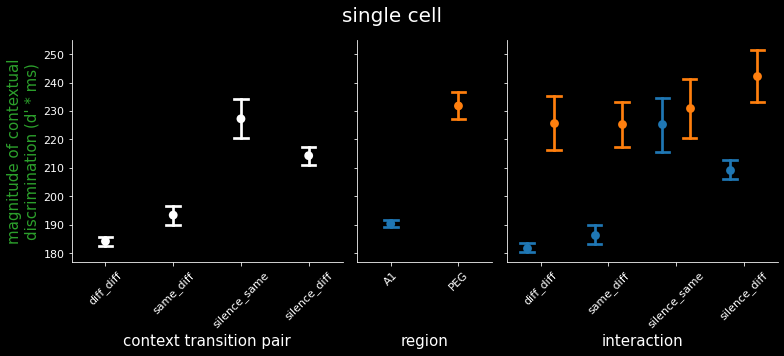

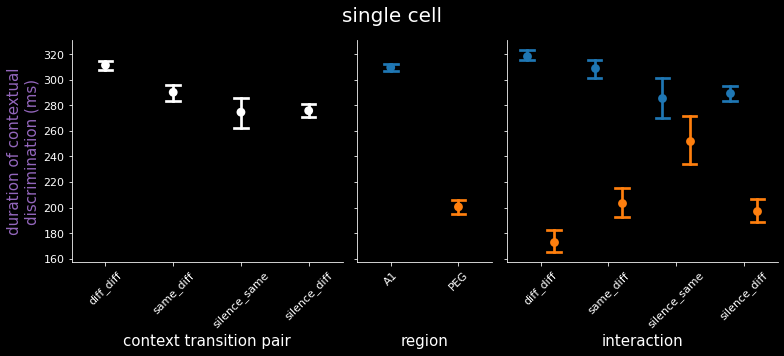

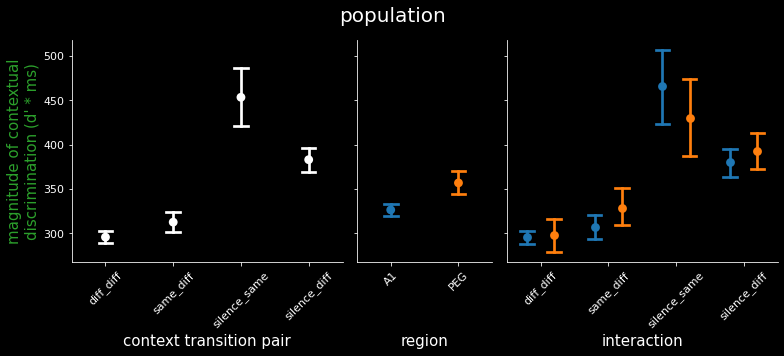

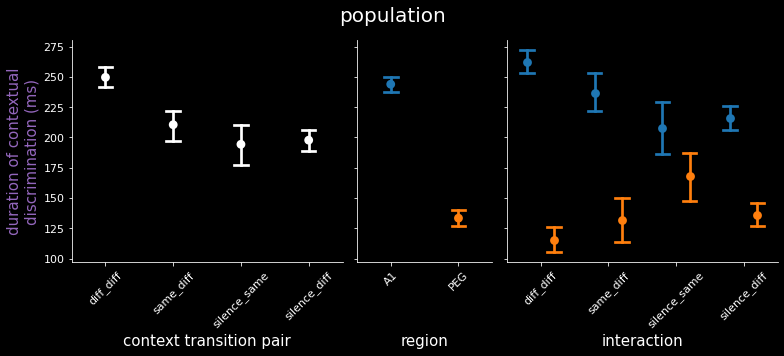

In [35]:
metrics = ["integral (d'*ms)", "center of mass (ms)"]
# analyses = ['single cell', 'population', 'probewise pop', 'pop ceiling']
analyses = ['single cell', 'population']
for analysis, metric in itt.product(analyses, metrics):
    tocalc = filtered.loc[(filtered.metric == metric) &
                          (filtered.analysis == analysis) &
                          (filtered.value >0),:]

    toplot = tocalc.loc[(tocalc.value < 600), :]

    if metric == "integral (d'*ms)":
        mname = 'integral'
        ylname = "magnitude of contextual\ndiscrimination (d' * ms)"
        lab_color = 'C2'
    elif metric == "center of mass (ms)":
        mname = 'center_of_mass'
        ylname = "duration of contextual\ndiscrimination (ms)"
        lab_color = 'C4'

    # plots the comparison by transition pair and by region in subplots of the same figures
    # gs_kw = dict(width_ratios=[1,0.5], height_ratios=[1])
    gs_kw = dict(width_ratios=[1, 0.5, 1], height_ratios=[1])
    # fig, (trans_ax, reg_ax) = plt.subplots(1, 2, sharey=True, gridspec_kw=gs_kw)
    fig, (trans_ax, reg_ax, int_ax) = plt.subplots(1, 3, sharey=True, gridspec_kw=gs_kw)
    fig.set_size_inches(11,5)

    #transitions
    _ = sns.pointplot(x='trans_pair', y='value', data=tocalc, order=trans_ord, hue_order=reg_ord,
                       s=2, dodge=0.4, join=False, palette=['white'], capsize=0.2, ci=68, ax=trans_ax)
    trans_ax.legend([],[], frameon=False)
    trans_ax.set_xticklabels(trans_ord, rotation = 45)

    trans_ax.set_xlabel('context transition pair')
    trans_ax.set_ylabel(ylname)
    trans_ax.yaxis.label.set_color(lab_color)

    # regions
    _ = sns.pointplot(x='region', y='value', data=tocalc, order=reg_ord, hue_order=reg_ord,
                       s=2, dodge=0.4, join=False, palette=sns.color_palette(), capsize=0.2, ci=68, ax=reg_ax)

    reg_ax.legend([],[], frameon=False)
    reg_ax.set_xticklabels(reg_ord, rotation = 45)
    reg_ax.set_xlabel('region')
    reg_ax.set_ylabel("")

    # interaction
    int_ax = sns.pointplot(x='trans_pair', y='value', hue='region', data=tocalc, order=trans_ord, hue_order=reg_ord,
                   s=2, dodge=0.4, join=False, capsize=0.2, ci=68, ax=int_ax)
    int_ax.legend([],[], frameon=False)
    int_ax.set_xticklabels(trans_ord, rotation = 45)
    int_ax.set_xlabel('interaction')
    int_ax.set_ylabel('')

    fig.align_labels()
    title =f'{analysis}_post_hoc_{mname}'
    fig.suptitle(f'{analysis}', fontsize=20)
    savefig(fig,'NGP_retreat', title)

# single cell population comparison

saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/SC_population_metric_comparison.png


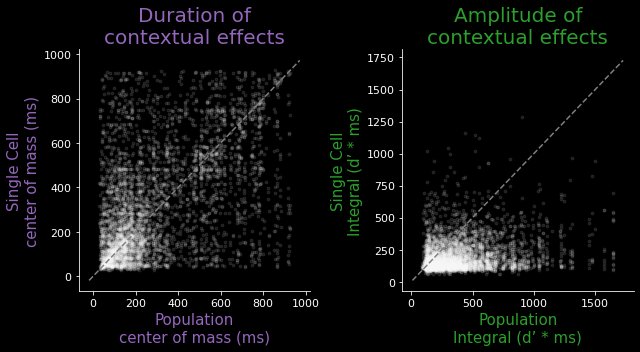

In [68]:
indexed = pivoted
indexed['siteid'] = pivoted['id'].apply(lambda x: x[:7] )
# indexed = indexed.set_index(['analysis', 'id', 'region', 'siteid', 'context_pair', 'trans_pair', 'probe'])
indexed = indexed.set_index(['analysis', 'siteid', 'probe', 'region', 'context_pair', 'trans_pair'])


analyses = ['probewise pop', 'pop ceiling', 'population']
analyses = ['population']
for analysis in analyses:
    merge = pd.merge(left=indexed.loc['single cell'], right=indexed.loc[analysis],
                     left_index=True, right_index=True,
                     suffixes=(' single cell', ' population'))
    # display(merge)

    filtmerge = merge.loc[(merge["integral (d'*ms) single cell"]>0) &
                          (merge["integral (d'*ms) population"]>0), :
                          ].drop(columns=(f'id population')).rename(columns={'id single cell': 'cellid'})

    fig, (dur_ax, amp_ax) = plt.subplots(1,2)
    fig.set_size_inches(9,5)

    dur_ax.scatter(filtmerge.loc[:,"center of mass (ms) population"], filtmerge.loc[:,"center of mass (ms) single cell"],
                   color='white', s=8, alpha=0.1)
    dur_ax.set_xlabel("Population\ncenter of mass (ms)")
    dur_ax.set_ylabel("Single Cell\ncenter of mass (ms)")
    dur_ax.xaxis.label.set_color('C4')
    dur_ax.yaxis.label.set_color('C4')
    dur_ax.set_title('Duration of\ncontextual effects', color='C4')

    amp_ax.scatter(filtmerge.loc[:,"integral (d'*ms) population"], filtmerge.loc[:,"integral (d'*ms) single cell"],
                   color='white', s=8, alpha=0.1)
    amp_ax.set_xlabel("Population\nIntegral (d’ * ms)")
    amp_ax.set_ylabel("Single Cell\nIntegral (d’ * ms)")
    amp_ax.xaxis.label.set_color('C2')
    amp_ax.yaxis.label.set_color('C2')
    amp_ax.set_title('Amplitude of\ncontextual effects', color='C2')

    for ax in (dur_ax, amp_ax):
        _ = unit_line(ax, True)

    title =f'SC_{analysis}_metric_comparison'
    savefig(fig, "NGP_retreat", title)


# Example cell

In [10]:
best_cells = pivoted.loc[(pivoted.analysis == 'single cell') &
                         (pivoted['center of mass (ms)'] > 0),
                         ['region', 'id', 'context_pair', 'trans_pair',
                          'probe', "center of mass (ms)", "integral (d'*ms)"]]
best_cells = best_cells.sort_values(by=["integral (d'*ms)", 'center of mass (ms)'], ascending=[False, False])
display(best_cells.head(5))

metric,region,id,context_pair,trans_pair,probe,center of mass (ms),integral (d'*ms)
34974,PEG,CRD012b-13-1,00_04,silence_diff,3,507.079994,1284.997683
10778,A1,TNC013a-22-2,03_09,same_diff,3,479.686724,1161.078267
26976,PEG,ARM021b-36-8,01_02,diff_diff,3,358.137677,1156.687105
26961,PEG,ARM021b-36-8,00_01,silence_diff,3,330.509103,1142.242546
2978,A1,AMT021b-05-2,01_02,same_diff,1,308.933576,1120.160911


# psth and dprime plots for example cells/sites

In [8]:
alpha=0.05

meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None,
        'stim_type': 'permutations'}

expt4 = {'contexts': [0, 1, 2, 3, 4],
         'probes': [1, 2, 3, 4]}

expt10 = {'contexts': list(range(11)),
        'probes': list(range(1,11))}


def load_all_raw_data(id, expt, fulldpca=True):

    # def analysis_steps_plot(id, probe):
    site = id[:7]
    if len(id) == 7:
        population = True
    else:
        population = False

    # loads the raw data
    raster, goodcells = _load_site_formated_raste(site, **expt, meta=meta)

    trialR, R, _ = format_raster(raster)

    if population and fulldpca:
        _, trialZ, dpca = _cpp_dPCA(R, trialR)
        trialR = trialZ['ct'][:, 0, ...][:,None,...]
        dprime, shuff_dprime_quantiles, goodcells, dPCA = full_dPCA_dprimes(site, **expt, meta=meta)

    elif population and not fulldpca:
        r, n, c, p, t = trialR.shape
        trialZ = np.empty((r, 1, c, p, t))
        for probe_idx in range(p):
            probe_trialR = trialR[..., probe_idx, :]
            probe_R = R[..., probe_idx, :]

            # calculates dPCA considering all 4 categories
            _, probe_trialZ, _ = _cpp_dPCA(probe_R, probe_trialR)
            trialZ[:, :, :, probe_idx, :] = probe_trialZ['ct'][:, 0, ...][:,None,...]

        trialR = trialZ
        dprime, shuff_dprime_quantiles, goodcells, dPCA = probewise_dPCA_dprimes(site, **expt, meta=meta)

    else:
        dprime, shuff_dprime_quantiles, goodcells, dPCA = single_cell_dprimes(site, **expt, meta=meta)

    significance, _ = _significance(dprime, shuff_dprime_quantiles, None, None, alpha=alpha)

    t = np.linspace(0, dprime.shape[-1] / meta['raster_fs'], dprime.shape[-1],
                    endpoint=False) * 1000

    return trialR, dprime, shuff_dprime_quantiles, significance, goodcells, t

In [7]:
def single_psth(trialR, cell_idx, trans_idx, probe_idx, ax):
    ax.plot(t, trialR[:, cell_idx, trans_idx, probe_idx, :].mean(axis=0), color=f'C{trans_idx}',
                     linewidth=3)
    return ax

def single_raster(trialR, cell_idx, trans_idx, probe_idx, ax):
    # plot raster only for single cells
    _ = _raster(t, trialR[:, cell_idx, trans_idx, probe_idx, :], y_offset=0, y_range=ax.get_ylim(), ax=ax,
                         scatter_kws={'color': f'C{trans_idx}', 'alpha': 0.4, 's': 10})
    return ax

# Paired PSTHs on the upper triangle
def double_psth(trialR, cell_idx, trans_idx_0, trans_idx_1, probe_idx, ax):
    ax.plot(t, trialR[:, cell_idx, trans_idx_0, probe_idx, :].mean(axis=0), color=f'C{trans_idx_0}',
                     linewidth=3)

    ax.plot(t, trialR[:, cell_idx, trans_idx_1, probe_idx, :].mean(axis=0), color=f'C{trans_idx_1}',
                     linewidth=3)
    return ax

# dprime plus CI on the lower triangle
def dprime_ci(dprime, confidence_interval, cell_idx, trans_idx_0, trans_idx_1, probe_idx, ax):
    trans_pair_idx = [f'{t0}_{t1}' for t0, t1 in itt.combinations(expt['contexts'], 2)
                      ].index(f'{trans_idx_0}_{trans_idx_1}')
    ax.plot(t, dprime[cell_idx, trans_pair_idx, probe_idx, :], color='white')
    ax.fill_between(t, confidence_interval[0, cell_idx, trans_pair_idx, probe_idx, :],
                    confidence_interval[1, cell_idx, trans_pair_idx, probe_idx, :],
                    color='white', alpha=0.5)
    return ax

# iterates over the grid
def grid_plot(id, trialR, dprime, confidence_interval, probe):

    cell_idx = goodcells.index(id) if len(id)>7 else 0
    probe_idx = expt['probes'].index(probe)

    fig = plt.figure(figsize=(8,8))

    n_ctx = trialR.shape[2] # Reps x Neurons x Contexts x Probex x TimePoints
    gs = fig.add_gridspec(n_ctx,n_ctx)

    first_up = True
    first_lo = True

    diagonals = list()
    for x, y in itt.product(range(n_ctx),range(n_ctx)):

        # creates subplots with shared x axis for the diagonal and upper triangle
        if x <= y:
            if first_up:
                upax = fig.add_subplot(gs[x,y])
                ax = upax
                first_up = False
            else:
                ax = fig.add_subplot(gs[x,y], sharex=upax, sharey=upax)
        else:
            if first_lo:
                loax = fig.add_subplot(gs[x,y])
                ax = loax
                first_lo = False
            else:
                ax = fig.add_subplot(gs[x,y], sharex=upax, sharey=loax)

        # plots upper triangle psth
        if x < y:
            _ = double_psth(trialR, cell_idx, x, y, probe_idx, ax)


        #plots lower triangle dprime
        elif x > y:
            _ = dprime_ci(dprime, confidence_interval, cell_idx, y, x, probe_idx, ax)

        # plots diagonal raster
        else:
            _ = single_psth(trialR, cell_idx, x, probe_idx, ax)
            diagonals.append(ax)

        # removes time tick labels
        if x != n_ctx-1:
            plt.setp(ax.get_xticklabels(), visible=False)

        # add time labels
        else:
            if y == int(n_ctx/2):
                ax.set_xlabel('time (ms)')

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # removes y tick lables
        if y not in [0,n_ctx-1]:
            plt.setp(ax.get_yticklabels(), visible=False)

        # remove y labels on the first psth
        if y == 0 and x == 0:
            plt.setp(ax.get_yticklabels(), visible=False)

        # dprime labels on left side
        if y == 0 and x == int(n_ctx/2):
            ax.set_ylabel("contextual effects discriminability (d')")

        # zscore firing rate ticks on right side
        if y == n_ctx-1:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
            if x == int(n_ctx/2):
                ax.set_ylabel('firing rate (z-score)')
            ax.spines['right'].set_visible(True)

    if len(id)>7:
        for n, ax in enumerate(diagonals):
            _ =single_raster(trialR, cell_idx, n, probe_idx, ax)
    else:
        for n, ax in enumerate(diagonals):
            ax.axhline(0, color='white', linestyle='--')

    return fig


In [9]:
# example for methods.
# id, probe, expt = 'CRD004a-39-2', 4, expt4 # <- great example 4 sounds
# id, probe, expt = 'TNC013a-22-2', 3, expt10 # <- great example 10 sounds, plot is too busy
id, probe, expt = 'ARM021b-36-8', 3, expt4 # <- great example 4 sounds
# id, probe, expt = 'ARM022b-16-1', 4, expt4 # <- great example 4 sounds

trialR, dprime, shuff_dprime_quantiles, significance, goodcells, t = load_all_raw_data(id, expt)
flipped_dprime, flipped_quantils = flip_dprimes(dprime, shuff_dprime_quantiles, flip='sum')
flipped_CI = flipped_quantils[alpha]


[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/ARM021b_b399e4c88724523c8dfc7043e82c710f52fc4d90.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Armillaria/ARM021/ARM021b06_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Armillaria/ARM021/ARM021b06_p_CPN.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Armillaria/ARM021/ARM021b07_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Armillaria/ARM021/ARM021b07_p_CPN.evp


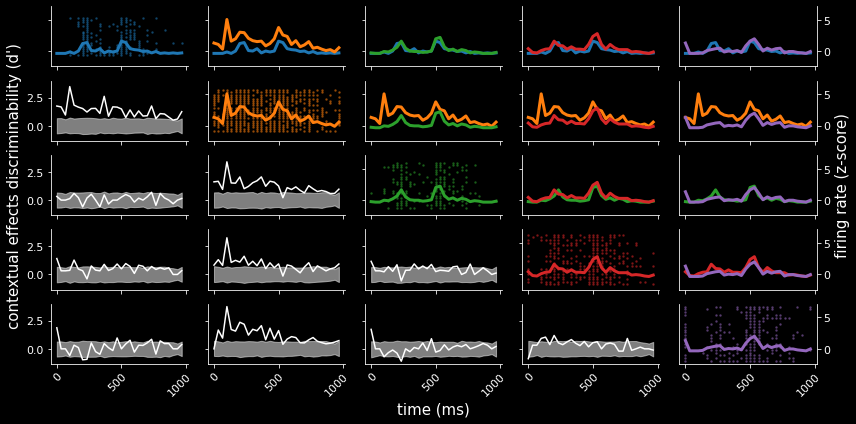

In [10]:
fig = grid_plot(id, trialR, flipped_dprime, flipped_CI, probe)
fig.set_size_inches(12,6)
title =f'context_pair_grid_{id}'
# savefig(fig, "NGP_retreat", title)

# PSTH with context included

In [26]:
print(expt)

def ctx_raster(id):
    site = id[:7]
    recs, params = load_with_parms(site, rasterfs=meta['raster_fs'], recache=False)
    sig = recs['perm0']['resp']

    # calculates response realiability and select only good cells to improve analysis
    r_vals, goodcells = signal_reliability(sig, r'\ASTIM_sequence*', threshold=meta['reliability'])
    goodcells = goodcells.tolist()

    # get the full data raster Context x Probe x Rep x Neuron x Time
    raster = raster_from_sig(sig, probes=expt['probes'], channels=goodcells, contexts=expt['contexts'],
                                              smooth_window=50, raster_fs=meta['raster_fs'],
                                              zscore=meta['zscore'], part='all')
    trialR, _, _ = format_raster(raster)

    return trialR

ctx_raster = ctx_raster(id)

{'contexts': [0, 1, 2, 3, 4], 'probes': [1, 2, 3, 4]}


saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/example_psth_ARM021b-36-8_[0].png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/example_psth_ARM021b-36-8_[0, 1].png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/example_psth_ARM021b-36-8_[0, 1, 2, 3, 4].png


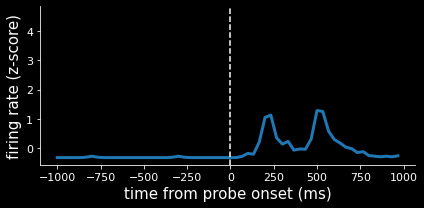

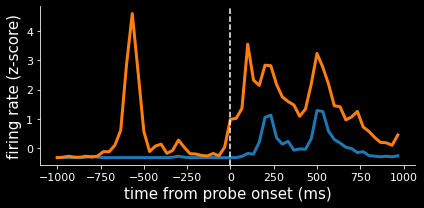

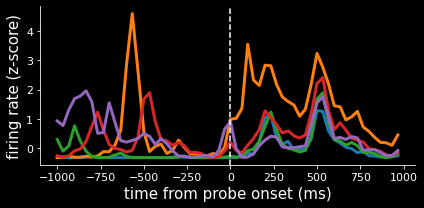

In [21]:
t =  np.linspace(-1, 1, ctx_raster.shape[-1],endpoint=False) * 1000
# plot a progression of added contexts
axes = []
figs = dict()
for contexts in ([0], [0,1], [0,1,2,3,4]):
    fig, ax = plt.subplots()
    axes.append(ax)
    _ = ax.plot(t, ctx_raster[:, goodcells.index(id), contexts, expt['probes'].index(probe), :].mean(axis=0).T, linewidth=3)
    ax.axvline(0, color='white', linestyle='--')

    ax.set_xlabel('time from probe onset (ms)')
    ax.set_ylabel('firing rate (z-score)')
    fig.set_size_inches(6,3)
    title = f'example_psth_{id}_{contexts}'
    figs[title] = fig

# defines common y range across all figures for easy transition in slides
y_range = np.asarray([ax.get_ylim() for ax in axes])
y_range = [np.min(y_range[:, 0]), np.max(y_range[:, 1])]

for ax in axes:
    ax.set_ylim(y_range)


for tit, fig in figs.items():
    savefig(fig, "NGP_retreat", tit)

# Non parametric metric explanation

In [210]:
def squarefy(t,y):
    """
    Takes a vector or 2d array meant to be ploted as lines, and transfroms into a format what when plooted, displays
    square time bins, like a histogram or PSTH.
    :param y: vector, or 2d array
    :param t:
    :return:
    """
    # duplicates y values to define left and right edges of square
    # duplicates and rolls t values so  y values are connected by either horizontal or vertical lines
    yy = np.repeat(y,2, axis=0)
    tt = np.roll(np.repeat(t, 2), -1)
    tt[-1] = tt[-2] + t[-1] - t[-2]
    return tt, yy

def non_param_example_plot(id, dprime, confidence_interval, significance, trans_idx_0, trans_idx_1, probe):
    cell_idx = goodcells.index(id) if len(id)>7 else 0
    probe_idx = expt['probes'].index(probe)
    trans_pair_idx = [f'{t0}_{t1}' for t0, t1 in itt.combinations(expt['contexts'], 2)
                      ].index(f'{trans_idx_0}_{trans_idx_1}')

    mean_dprime = dprime[cell_idx, trans_pair_idx, probe_idx, :]
    mean_signif = significance[cell_idx, trans_pair_idx, probe_idx, :]
    CI = confidence_interval[:,cell_idx, trans_pair_idx, probe_idx, :]
    signif_mask = mean_signif>0
    t =  np.linspace(0, 1, mean_dprime.shape[-1],endpoint=False) * 1000

    # calculates center of mass and integral
    significant_abs_mass_center = np.sum(np.abs(mean_dprime[signif_mask]) * t[signif_mask]) / np.sum(np.abs(mean_dprime[signif_mask]))
    significant_abs_sum = np.sum(np.abs(mean_dprime[signif_mask])) * np.mean(np.diff(t))

    fig, axes = plt.subplots()

    # plots dprime plus fit
    tt, mmdd = squarefy(t, mean_dprime)
    axes.plot(tt, mmdd, color='white', linewidth=2)
    _, CCII = squarefy(t, CI.T)
    axes.fill_between(tt, CCII[:,0], CCII[:,1], color='white', alpha=0.3)
    _ = axes.axhline(0, color='white', linewidth=1, linestyle='--', alpha=0.5)

    p1 = axes.fill_between(tt, 0, mmdd, where=np.repeat(signif_mask,2), color='C2', alpha=0.8,
                           label=f"integral\n{significant_abs_sum:.2f} d'*ms")

    p2 = axes.axvline(significant_abs_mass_center, color='C4', linewidth=4, linestyle='--',
                 label=f'center of mass\n{significant_abs_mass_center:.2f} ms')

    axes.legend(handles=[p1, p2], loc='upper right')
    # plt.legend(handles=[p1, p2], bbox_to_anchor=(1.05, 1), loc='upper left')

    # formats axis, legend and so on.
    axes.set_ylabel(f"contextual effects discriminability (d')")
    axes.set_xlabel('time (ms)')

    return fig, axes

## raw and with multiple comparisons correction

saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/mult_comp_corr_ARM021b-36-8_consecutive_4_prb3_ctx0_1.png


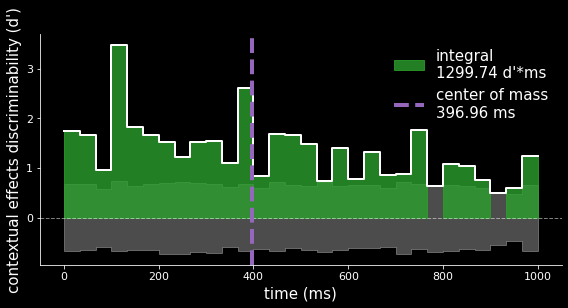

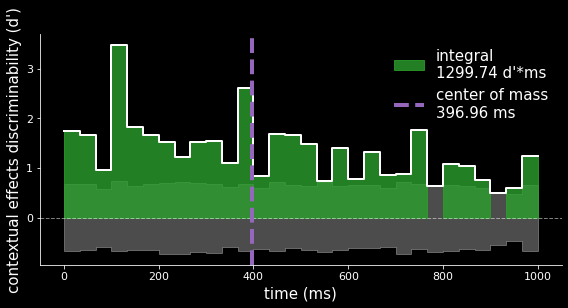

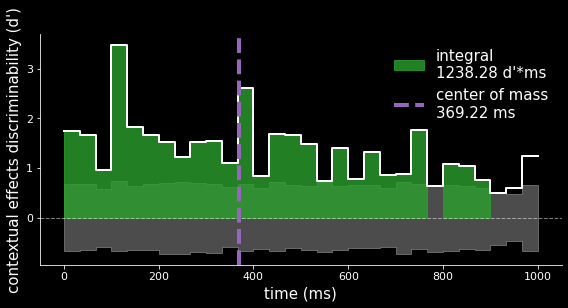

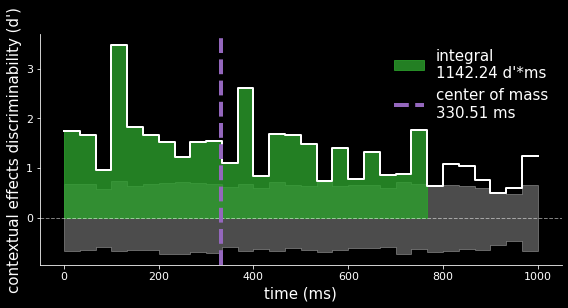

In [216]:
# keywords take from 210302_batch_dprimes_significance.py
multiple_corrections = {'none': (None, None),
                        'consecutive_2': ([3], 2),
                        'consecutive_3': ([3], 3),
                        'consecutive_4': ([3], 4)}
ctx0, ctx1 = 0, 1

for key, (corr_ax, n_cons) in multiple_corrections.items():
    corr_signif, _ = _significance(dprime, shuff_dprime_quantiles, corr_ax, n_cons, alpha=alpha)
    fig, ax = non_param_example_plot(id, flipped_dprime, flipped_CI, corr_signif, ctx0, ctx1, probe)
    fig.set_size_inches(8, 4)
    title = f'mult_comp_corr_{id}_{key}_prb{probe}_ctx{ctx0}_{ctx1}'

    if key == f'consecutive_{mult_comp_cont}':
        savefig(fig, "NGP_retreat", title)

# population example

In [69]:
# selecs sites based on metric values
sorted_SC_pop = filtmerge.sort_values(by=["integral (d'*ms) population", "center of mass (ms) population",
                                  "integral (d'*ms) single cell", "center of mass (ms) single cell"],
                              ascending=[False,False,False,False])

display(sorted_SC_pop.head(10))

metric                                                cellid  \
siteid  probe region context_pair trans_pair                   
ARM031a 1     A1     00_03        silence_diff  ARM031a-54-3   
                                  silence_diff  ARM031a-51-4   
                                  silence_diff  ARM031a-58-3   
                                  silence_diff  ARM031a-24-9   
                                  silence_diff  ARM031a-49-3   
                                  silence_diff  ARM031a-15-2   
                                  silence_diff  ARM031a-52-6   
        2     A1     00_03        silence_diff  ARM031a-24-9   
                                  silence_diff  ARM031a-54-3   
                                  silence_diff  ARM031a-15-2   

metric                                          center of mass (ms) single cell  \
siteid  probe region context_pair trans_pair                                      
ARM031a 1     A1     00_03        silence_diff                       210.547712   
                                  silence_diff                       207.789554   
                                  silence_diff                       334.955373   
                                  silence_diff                       138.081148   
                                  silence_diff                       385.178247   
                                  silence_diff                       153.055472   
                                  silence_diff                       155.225393   
        2     A1     00_03        silence_diff                       134.100473   
                                  silence_diff                       285.639550   
                                  silence_diff                        86.120359   

metric                                          integral (d'*ms) single cell  \
siteid  probe region context_pair trans_pair                                   
ARM031a 1     A1     00_03        silence_diff                    691.987013   
                                  silence_diff                    543.199967   
                                  silence_diff                    537.845526   
                                  silence_diff                    482.090302   
                                  silence_diff                    193.293061   
                                  silence_diff                    131.243372   
                                  silence_diff                     99.762763   
        2     A1     00_03        silence_diff                    492.941168   
                                  silence_diff                    471.559357   
                                  silence_diff                    229.899594   

metric                                          center of mass (ms) population  \
siteid  probe region context_pair trans_pair                                     
ARM031a 1     A1     00_03        silence_diff                      236.099362   
                                  silence_diff                      236.099362   
                                  silence_diff                      236.099362   
                                  silence_diff                      236.099362   
                                  silence_diff                      236.099362   
                                  silence_diff                      236.099362   
                                  silence_diff                      236.099362   
        2     A1     00_03        silence_diff                      316.842740   
                                  silence_diff                      316.842740   
                                  silence_diff                      316.842740   

metric                                          integral (d'*ms) population  
siteid  probe region context_pair trans_pair                                 
ARM031a 1     A1     00_03        silence_diff                  1649.187099  
                                  silence_diff        

In [170]:
# get a list of the 2 best and 2 worst cells at this site
site, probe, expt = 'ARM031a', 1, expt4 # <- best site
sorted_cells = sorted_SC_pop.loc[(site, probe),'cellid'].values
best_cells = sorted_cells[:2].tolist()
worst_cells = sorted_cells[-2:].tolist()

cells = best_cells + worst_cells
print(cells)

['ARM031a-54-3', 'ARM031a-51-4', 'ARM031a-30-6', 'ARM031a-15-2']


/auto/users/mateo/miniconda3/envs/context_probe_analysis2/lib/python3.8/site-packages/pandas/core/indexing.py:889: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/ARM031a_f6a1e774c711b10812d095ad854d2ba70131f4b8.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Armillaria/ARM031/ARM031a10_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Armillaria/ARM031/ARM031a10_p_CPN.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Armillaria/ARM031/ARM031a11_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Armillaria/ARM031/ARM031a11_p_CPN.evp


You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.003388200529767837
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


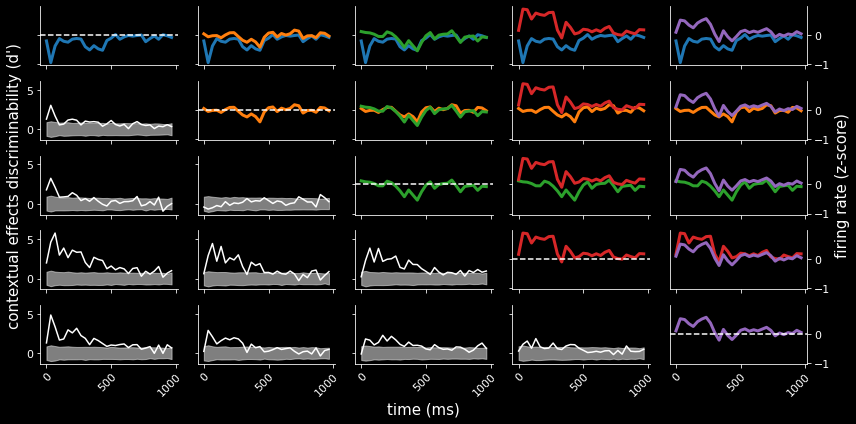

In [171]:
trialR, dprime, shuff_dprime_quantiles, significance, goodcells, t = load_all_raw_data(site, expt)
flipped_dprime, flipped_quantils = flip_dprimes(dprime, shuff_dprime_quantiles, flip='sum')
flipped_CI = flipped_quantils[alpha]

fig = grid_plot(site, trialR, flipped_dprime, flipped_CI, probe)
fig.set_size_inches(12,6)
title =f'context_pair_grid_{site}'
# savefig(fig, "NGP_retreat", title)

[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/ARM031a_f6a1e774c711b10812d095ad854d2ba70131f4b8.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Armillaria/ARM031/ARM031a10_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Armillaria/ARM031/ARM031a10_p_CPN.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Armillaria/ARM031/ARM031a11_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Armillaria/ARM031/ARM031a11_p_CPN.evp
[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/ARM031a_f6a1e774c711b10812d095ad854d2ba70131f4b8.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Armillaria/ARM031/ARM031a10_p_CPN.m
[nems_lbhb.baphy_io I

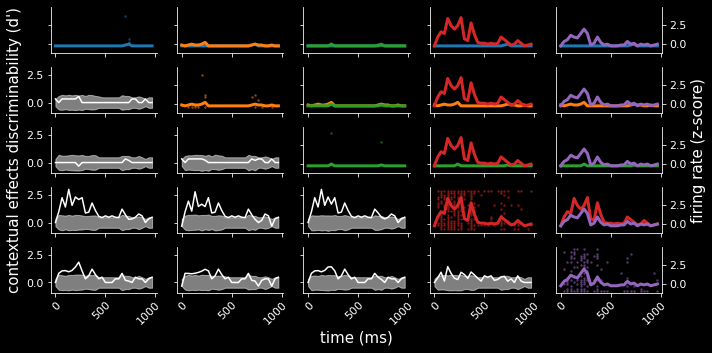

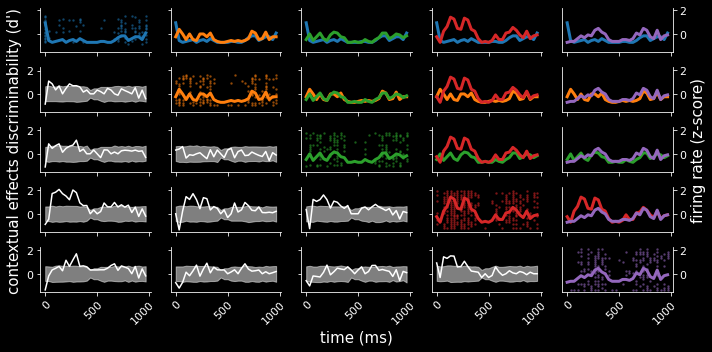

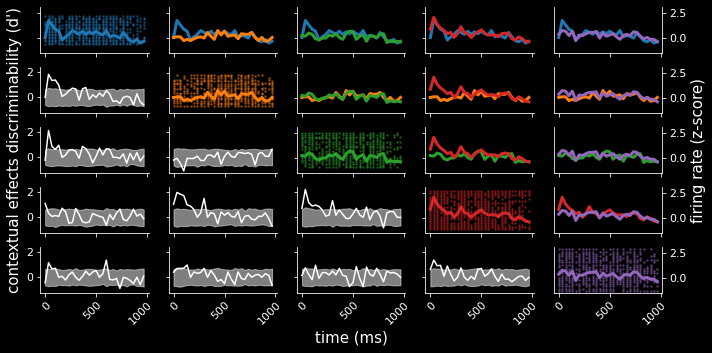

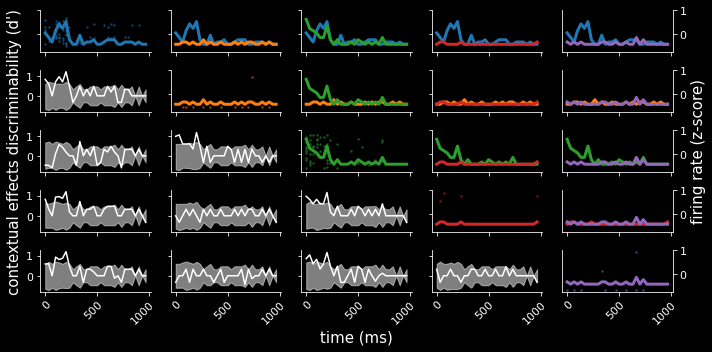

In [172]:
for cell in cells:
    trialR, dprime, shuff_dprime_quantiles, significance, goodcells, t = load_all_raw_data(cell, expt)
    flipped_dprime, flipped_quantils = flip_dprimes(dprime, shuff_dprime_quantiles, flip='sum')
    flipped_CI = flipped_quantils[alpha]

    fig = grid_plot(cell, trialR, flipped_dprime, flipped_CI, probe)
    fig.set_size_inches(10,5)
    title =f'context_pair_grid_{cell}'
    # savefig(fig, "NGP_retreat", title)


# subsampling analysis

In [168]:
def nonan_proportion(arr):
    return np.sum(~np.isnan(arr))/arr.size * 100


def nozero_percentage(arr):
    return np.sum(arr>0) / np.size(arr) * 100

def nozero_proportion(arr):
    return np.sum(arr>0) / np.size(arr)

In [85]:
# filteres dataframe and adds required columns
filtered = pivoted.loc[pivoted.analysis=='single cell', :]
filtered['site'] = filtered.id.apply(lambda x: x[:7])

ctx_pairs = [pair.split('_') for pair in filtered.context_pair]
ctx_pairs = np.stack(ctx_pairs, axis=0)
filtered['ctx_0'] = ctx_pairs[:, 0]
filtered['ctx_1'] = ctx_pairs[:, 1]

# function to aggregate each single cell. gives the proportion of significant instances
agg_funcs = {"signif_proportion": ("integral (d'*ms)", nozero_percentage)}


<ipython-input-85-fad7368a9c80>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['site'] = filtered.id.apply(lambda x: x[:7])
<ipython-input-85-fad7368a9c80>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['ctx_0'] = ctx_pairs[:, 0]
<ipython-input-85-fad7368a9c80>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [105]:
# iterates over all sizes of probe subsampling, i.e. 1, 2, 3 and 4 probes.
prb_subsampling_path = pl.Path(config['paths']['analysis_cache']) / '210913_prb_subsampling_DF'
recache_prb = False
if (not prb_subsampling_path.exists())  or recache_prb:
    print(f'creating prb_subsamp_signif dataframe')
    all_probes = filtered.probe.sort_values().unique()
    prb_subsamp_signif = pd.DataFrame()

    for num_probe in range(len(all_probes)):
        num_probe += 1

        n_probe_groups  = list(itt.combinations(all_probes, num_probe))
        # iterates over all possible combinations of n probes
        for pg, probe_group in enumerate(n_probe_groups):
            probe_group = [int(p) for p in probe_group]
            probes_df = filtered.loc[filtered.probe.isin(probe_group), :].set_index('region', 'site', 'id')
            grouped  = probes_df.groupby(['region', 'site', 'id']).agg(**agg_funcs).copy()
            grouped.loc[grouped.signif_proportion == 0] = np.nan
            grouped['n_probes'] = num_probe
            grouped['prb_group'] = '_'.join([str(p) for p in probe_group])
            prb_subsamp_signif = prb_subsamp_signif.append(grouped.reset_index())


    jl.dump(prb_subsamp_signif, prb_subsampling_path)
    print(f'prb_subsamp_signif chached at {prb_subsampling_path}')

else:
    print(f'loading prb_subsamp_signif from {prb_subsampling_path}')
    prb_subsamp_signif = jl.load(prb_subsampling_path)

display(prb_subsamp_signif)

creating prb_subsamp_signif dataframe
prb_subsamp_signif chached at /home/mateo/code/context_probe_analysis/data/210913_prb_subsampling_DF


,region,site,id,signif_proportion,n_probes,prb_group
0,A1,AMT020a,AMT020a-02-1,NaN,1,1
1,A1,AMT020a,AMT020a-04-1,NaN,1,1
2,A1,AMT020a,AMT020a-07-1,NaN,1,1
3,A1,AMT020a,AMT020a-08-1,NaN,1,1
4,A1,AMT020a,AMT020a-13-1,NaN,1,1
...,...,...,...,...,...,...
1104,PEG,CRD014b,CRD014b-24-2,5.0,10,1_2_3_4_5_6_7_8_9_10
1105,PEG,CRD014b,CRD014b-27-1,NaN,10,1_2_3_4_5_6_7_8_9_10
1106,PEG,CRD014b,CRD014b-27-2,NaN,10,1_2_3_4_5_6_7_8_9_10
1107,PEG,CRD014b,CRD014b-27-3,NaN,10,1_2_3_4_5_6_7_8_9_10


In [117]:
# iterates over all sizes of context subsampling, i.e. 2, 3, 4 and 5 contexts.
ctx_subsampling_path = pl.Path(config['paths']['analysis_cache']) / '210913_ctx_subsampling_DF'
recache_ctx = False
if (not ctx_subsampling_path.exists()) or recache_ctx:
    print(f'creating ctx_subsamp_signif dataframe')
    all_contexts = np.unique(ctx_pairs)
    ctx_subsamp_signif = pd.DataFrame()

    for num_ctx in range(2, len(all_contexts)+1):
        n_ctx_groups  = list(itt.combinations(all_contexts, num_ctx))
        # iterates over all possible combinations of n probes
        for cg, ctx_group in enumerate(n_ctx_groups):
            ctx_df = filtered.loc[(filtered.ctx_0.isin(ctx_group)) &
                                     ((filtered.ctx_1.isin(ctx_group))), :].set_index('region', 'site', 'id')
            grouped  = ctx_df.groupby(['region', 'site', 'id']).agg(**agg_funcs).copy()
            grouped.loc[grouped.signif_proportion == 0] = np.nan
            grouped['n_contexts'] = num_ctx
            grouped['ctx_group'] = '_'.join(ctx_group)
            ctx_subsamp_signif = ctx_subsamp_signif.append(grouped.reset_index())

    jl.dump(ctx_subsamp_signif, ctx_subsampling_path)
    print(f'ctx_subsamp_signif chached at {ctx_subsampling_path}')
else:
    print(f'loading ctx_subsamp_signif from {ctx_subsampling_path}')
    ctx_subsamp_signif = jl.load(ctx_subsampling_path)

display(ctx_subsamp_signif)

loading ctx_subsamp_signif from /home/mateo/code/context_probe_analysis/data/210913_ctx_subsampling_DF


,region,site,id,signif_proportion,n_contexts,ctx_group
0,A1,AMT020a,AMT020a-02-1,NaN,2,00_01
1,A1,AMT020a,AMT020a-04-1,NaN,2,00_01
2,A1,AMT020a,AMT020a-07-1,NaN,2,00_01
3,A1,AMT020a,AMT020a-08-1,NaN,2,00_01
4,A1,AMT020a,AMT020a-13-1,NaN,2,00_01
...,...,...,...,...,...,...
1104,PEG,CRD014b,CRD014b-24-2,5.0,11,00_01_02_03_04_05_06_07_08_09_10
1105,PEG,CRD014b,CRD014b-27-1,NaN,11,00_01_02_03_04_05_06_07_08_09_10
1106,PEG,CRD014b,CRD014b-27-2,NaN,11,00_01_02_03_04_05_06_07_08_09_10
1107,PEG,CRD014b,CRD014b-27-3,NaN,11,00_01_02_03_04_05_06_07_08_09_10


## Proportion of significant instances per neuron
only looking at cells with at least one significant instance

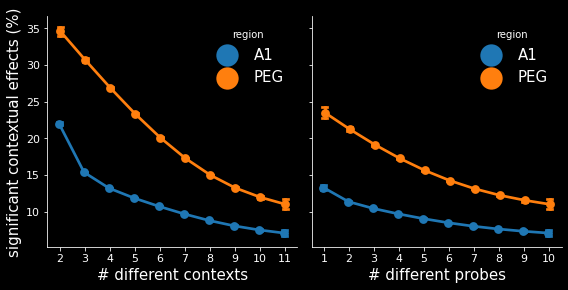

In [111]:
fig, (ctx_ax, prb_ax) = plt.subplots(1, 2, sharey=True, figsize=[8,4])
_ = sns.pointplot(x='n_contexts', y='signif_proportion', data=ctx_subsamp_signif, hue='region',
                  dodge=True, s=2, capsize=0.2, ci=68, ax=ctx_ax)
_ = sns.pointplot(x='n_probes', y='signif_proportion', data=prb_subsamp_signif, hue='region',
                  dodge=True, s=2, capsize=0.2, ci=68, ax=prb_ax)

ctx_ax.set_xlabel('# different contexts')
prb_ax.set_xlabel('# different probes')

ctx_ax.set_ylabel('significant contextual effects (%)')
prb_ax.set_ylabel('')
# ctx_ax.legend([],[], frameon=False)
# prb_ax.legend([],[], frameon=False)
title = 'stim subsampling instance per neuron'
# savefig(fig, 'NGP_retreat', title)

## count of significant cells by site and or region
### all together

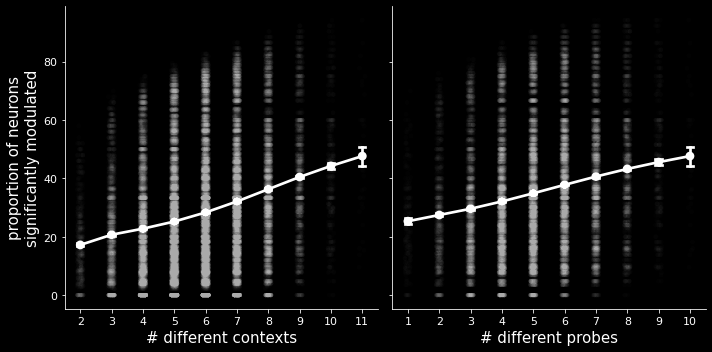

In [116]:
# collapses across neurons. Keeps information about region and ctx / prb subsamples.

ctx_count_by_site = ctx_subsamp_signif.set_index(['region','site', 'n_contexts','ctx_group']
                                     ).groupby(['region', 'site', 'n_contexts','ctx_group']
                                     ).agg(signfi_cell_prop=('signif_proportion', nonan_proportion)).reset_index()

prb_count_by_site = prb_subsamp_signif.set_index(['region','site', 'n_probes','prb_group']
                                     ).groupby(['region', 'site', 'n_probes','prb_group']
                                     ).agg(signfi_cell_prop=('signif_proportion', nonan_proportion)).reset_index()

In [ ]:
color = 'white'

fig, (ctx_ax, prb_ax) = plt.subplots(1, 2, sharey=True, figsize=[10,5])
_ = sns.pointplot(x='n_contexts', y='signfi_cell_prop', color=color, data=ctx_count_by_site,
                  dodge=True, s=2, capsize=0.2, ci=68, ax=ctx_ax,)
_ = sns.stripplot(x='n_contexts', y='signfi_cell_prop', color=color, data=ctx_count_by_site,
                  dodge=True, alpha=0.01, ax=ctx_ax)
ctx_ax.legend([],[], frameon=False)
ctx_ax.set_xlabel('# different contexts')
ctx_ax.set_ylabel('proportion of neurons\nsignificantly modulated')


_ = sns.pointplot(x='n_probes', y='signfi_cell_prop', color=color, data=prb_count_by_site,
                  dodge=True, s=2, capsize=0.2, ci=68, ax=prb_ax)
_ = sns.stripplot(x='n_probes', y='signfi_cell_prop', color=color, data=prb_count_by_site,
                  dodge=True, alpha=0.01, ax=prb_ax)
prb_ax.legend([],[], frameon=False)
prb_ax.set_xlabel('# different probes')
prb_ax.set_ylabel('')

title = 'proportion of significantly modulated neurons pers site'

# savefig(fig, 'NGP_retreat', title)

### by region

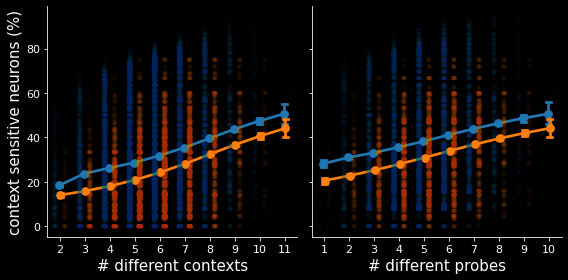

In [113]:
fig, (ctx_ax, prb_ax) = plt.subplots(1, 2, sharey=True, figsize=[8,4])
_ = sns.pointplot(x='n_contexts', y='signfi_cell_prop', hue='region', data=ctx_count_by_site,
                  dodge=True, s=2, capsize=0.2, ci=68, ax=ctx_ax,)
_ = sns.stripplot(x='n_contexts', y='signfi_cell_prop', hue='region', data=ctx_count_by_site,
                  dodge=True, alpha=0.01, ax=ctx_ax)

_ = sns.pointplot(x='n_probes', y='signfi_cell_prop', hue='region', data=prb_count_by_site,
                  dodge=True, s=2, capsize=0.2, ci=68, ax=prb_ax)
_ = sns.stripplot(x='n_probes', y='signfi_cell_prop', hue='region', data=prb_count_by_site,
                  dodge=True, alpha=0.01, ax=prb_ax)

ctx_ax.legend([],[], frameon=False)
ctx_ax.set_xlabel('# different contexts')
ctx_ax.set_ylabel('context sensitive neurons (%)')

prb_ax.legend([],[], frameon=False)
prb_ax.set_xlabel('# different probes')
prb_ax.set_ylabel('')

title = 'stim subsampling cells per region'
# savefig(fig, 'NGP_retreat', title)

### by site

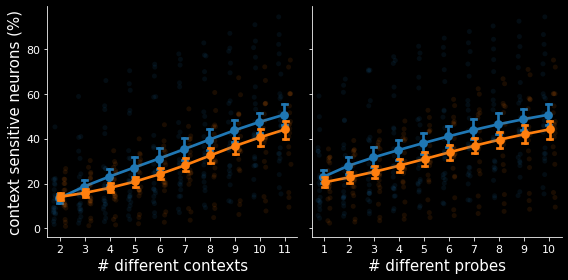

In [114]:
# collapses across neurons, grouping by site. Keeps information about region and ctx / prb subsamples.

ctx_count_by_site = ctx_subsamp_signif.set_index(['region','site', 'n_contexts','ctx_group']
                                     ).groupby(['region', 'site', 'n_contexts','ctx_group']
                                     ).agg(signfi_cell_prop=('signif_proportion', nonan_proportion)
                                     ).groupby(['region', 'site', 'n_contexts']
                                     ).agg(signfi_cell_prop=('signfi_cell_prop', np.nanmean)).reset_index()

prb_count_by_site = prb_subsamp_signif.set_index(['region','site', 'n_probes','prb_group']
                                     ).groupby(['region', 'site', 'n_probes','prb_group']
                                     ).agg(signfi_cell_prop=('signif_proportion', nonan_proportion)
                                     ).groupby(['region', 'site', 'n_probes']
                                     ).agg(signfi_cell_prop=('signfi_cell_prop', np.nanmean)).reset_index()


fig, (ctx_ax, prb_ax) = plt.subplots(1, 2, sharey=True, figsize=[8,4])
_ = sns.pointplot(x='n_contexts', y='signfi_cell_prop', hue='region', data=ctx_count_by_site,
                  dodge=True, s=2, capsize=0.2, ci=68, ax=ctx_ax,)
_ = sns.stripplot(x='n_contexts', y='signfi_cell_prop', hue='region', data=ctx_count_by_site,
                  dodge=True, alpha=0.1, ax=ctx_ax)

_ = sns.pointplot(x='n_probes', y='signfi_cell_prop', hue='region', data=prb_count_by_site,
                  dodge=True, s=2, capsize=0.2, ci=68, ax=prb_ax)
_ = sns.stripplot(x='n_probes', y='signfi_cell_prop', hue='region', data=prb_count_by_site,
                  dodge=True, alpha=0.1, ax=prb_ax)

ctx_ax.legend([],[], frameon=False)
ctx_ax.set_xlabel('# different contexts')
ctx_ax.set_ylabel('context sensitive neurons (%)')

prb_ax.legend([],[], frameon=False)
prb_ax.set_xlabel('# different probes')
prb_ax.set_ylabel('')

title = 'stim subsampling cells per site'
# savefig(fig, 'NGP_retreat', title)

# start from 10 sounds port
## Histograms
 of number of neurons responsive to different number of contexts-pairs, probes or context-pair-probes

In [129]:
np.any(np.isnan(pivoted['center of mass (ms)'].values))

False

In [132]:
agg_funcs = {"integration instance proportion": ("integral (d'*ms)", nozero_proportion)}

ctx_prb_count = pivoted.set_index(['analysis', 'region', 'id']
                              ).groupby(['analysis', 'region', 'id']
                              ).agg(**agg_funcs).reset_index()

### sigle neuron

saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/modulated neurons histogram.png


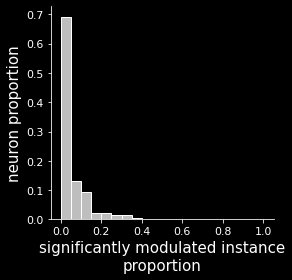

In [207]:
fig, ax = plt.subplots()
# ax.set_title('context-pair probe\ninstances')

hist_data = ctx_prb_count.loc[ctx_prb_count.analysis =='single cell', :]
_ = sns.histplot(data=hist_data,x='integration instance proportion', ax=ax, color='white', stat='probability',
                 bins=20, binrange=[0,1], common_norm=False)
ax.set_xlabel('significantly modulated instance\nproportion')
ax.set_ylabel('neuron proportion')

title = f'modulated neurons histogram'
savefig(fig, 'NGP_retreat', title)

### population

saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/modulated site histogram.png


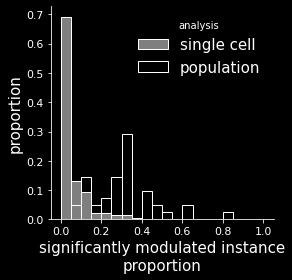

In [208]:
fig, ax = plt.subplots()
# ax.set_title('context-pair probe\ninstances')
hist_data = ctx_prb_count
out = sns.histplot(data=hist_data,x='integration instance proportion', ax=ax, hue='analysis',
                 hue_order=['single cell', 'population'], palette=['white','black'], stat='probability',
                 bins=20, binrange=[0,1], common_norm=False)
ax.set_xlabel('significantly modulated instance\nproportion')
ax.set_ylabel('proportion')

title = f'modulated site histogram'
savefig(fig, 'NGP_retreat', title)

# neuron (or PC) fingerprint
it displays all probes on the y axis and combinations of context-pairs on the x axis

In [226]:
ana = 'signle cell'
ana = 'population'

pivot_ready = full_long.loc[full_long.analysis == ana,
                            ['region', 'id', 'context_pair', 'probe', 'metric', 'value']]
pivot_ready['site'] = pivot_ready.id.apply(lambda x: x[:7])

summary = pivot_ready.pivot_table(values='value', index=['region', 'site', 'id', 'probe'],
                                  columns=['metric', 'context_pair'], fill_value=np.nan)

summary.index = summary.index.droplevel([0, 1])

best_neurons = pivot_ready.set_index(['metric', 'id']
               ).loc[["integral (d'*ms)"], :
               ].groupby(['id']
               ).agg(np.nanmean)

best_neurons = best_neurons.sort_values(by=['value'], axis=0, ascending=False)
print('sorted best neurons')
display(best_neurons.head(20))

sorted best neurons


,probe,value
id,,
ARM031a,2.5,551.487876
CRD004a,2.5,307.849703
ARM017a,2.5,307.154300
TNC018a,5.5,221.122059
ARM022b,2.5,185.053232
TNC013a,5.5,178.142889
AMT029a,2.5,175.842396
ARM024a,2.5,153.658354
AMT021b,2.5,150.294967


saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/population TNC013a integral (d'*ms) barcode.png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/population TNC013a center of mass (ms) barcode.png


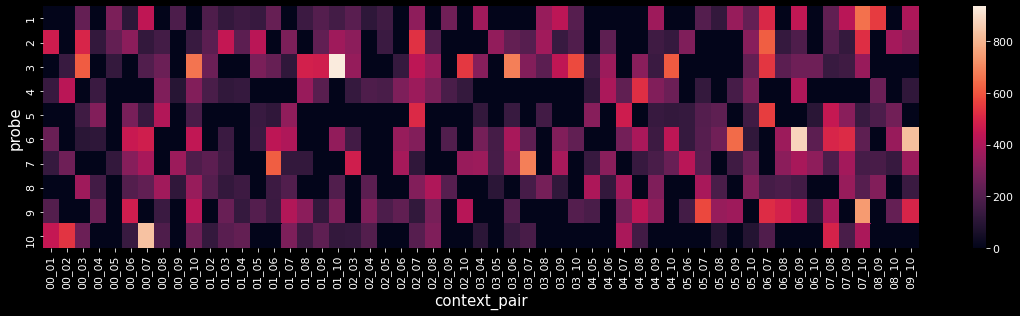

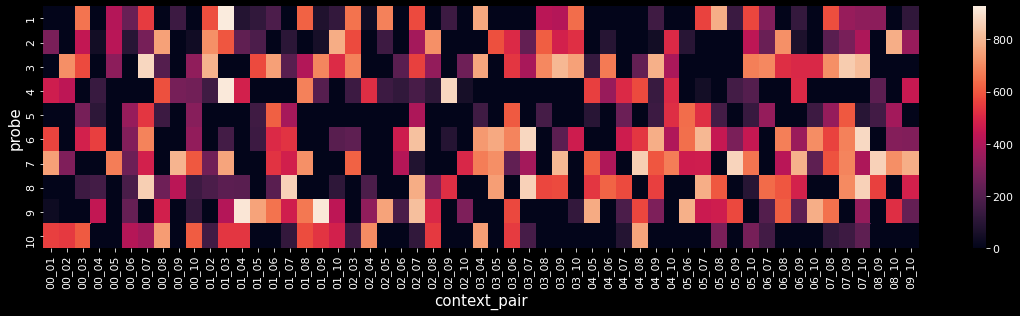

In [227]:
metrics = ["integral (d'*ms)", "center of mass (ms)"]
# cells = ['ARM021b-36-8', 'TNC014a-22-1'] # best
cells = ['ARM022b-16-1', 'TNC013a-22-2'] # second best, coinciding with best sites
cells = ['TNC013a'] # one of best population analysis

for cell, metric in itt.product(cells, metrics):
    cell_barcode = summary.loc[[cell], [metric]]
    cell_barcode = cell_barcode.droplevel(level=0, axis=0).droplevel(level=0, axis=1).dropna(axis=1, how='all')
    fig, ax = plt.subplots(figsize=(16,4.5))
    ax = sns.heatmap(data=cell_barcode, ax=ax)

    title = f'{ana} {cell} {metric} barcode'
    savefig(fig, 'NGP_retreat', title)

plt.show()

# site fingerprint
it displays all the neurons on the y axis and combinations of context-pairs_probes on the x axis

In [203]:
pivot_ready = full_long.loc[full_long.analysis == 'single cell',
                            ['region', 'id', 'trans_pair', 'context_pair', 'probe', 'metric', 'value']]
pivot_ready['site'] = pivot_ready.id.apply(lambda x: x[:7])


summary = pivot_ready.pivot_table(values='value', index=['region', 'site', 'id'],
                                  columns=['metric', 'probe', 'trans_pair', 'context_pair'], fill_value=np.nan)

summary.index = summary.index.droplevel(0)

best_sites = pivot_ready.set_index(['metric', 'site']
               ).loc[["integral (d'*ms)"], :
               ].groupby(['site']
               ).agg(np.nanmean)

best_sites = best_sites.sort_values(by=['value'], axis=0, ascending=False)
print('sorted best sites')
display(best_sites.head(10))

sorted best sites


,probe,value
site,,
ARM022b,2.5,28.904793
ARM017a,2.5,20.448572
ARM027a,2.5,19.696355
ARM031a,2.5,19.391087
TNC013a,5.5,19.053576
ARM021b,2.5,18.000581
CRD011c,2.5,17.932938
ARM026b,2.5,14.733499
ARM005e,2.5,14.410041


saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/ARM022b integral (d'*ms) barcode 10.png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/ARM022b center of mass (ms) barcode 10.png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/TNC013a integral (d'*ms) barcode 10.png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/TNC013a center of mass (ms) barcode 10.png


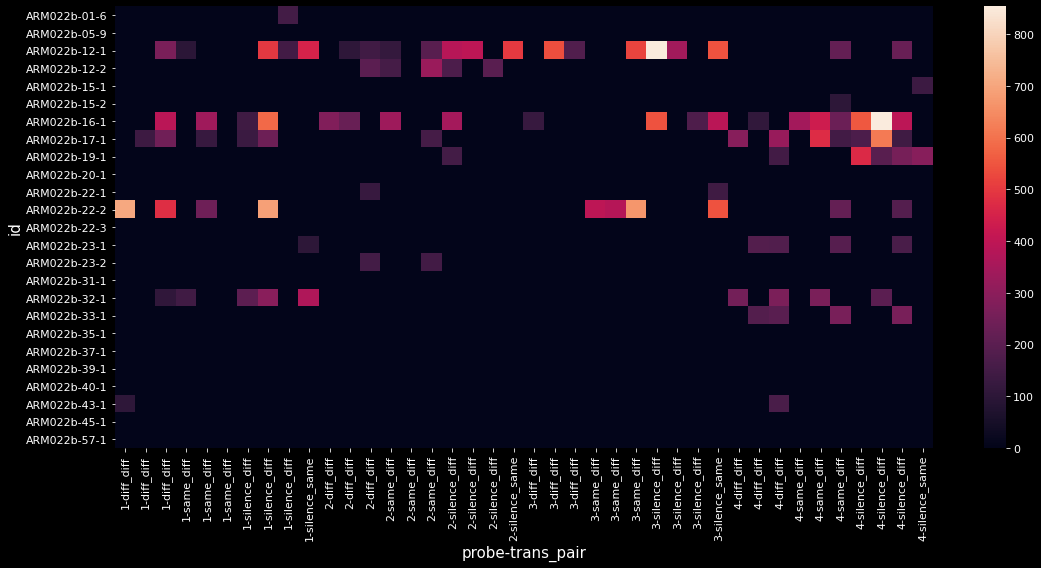

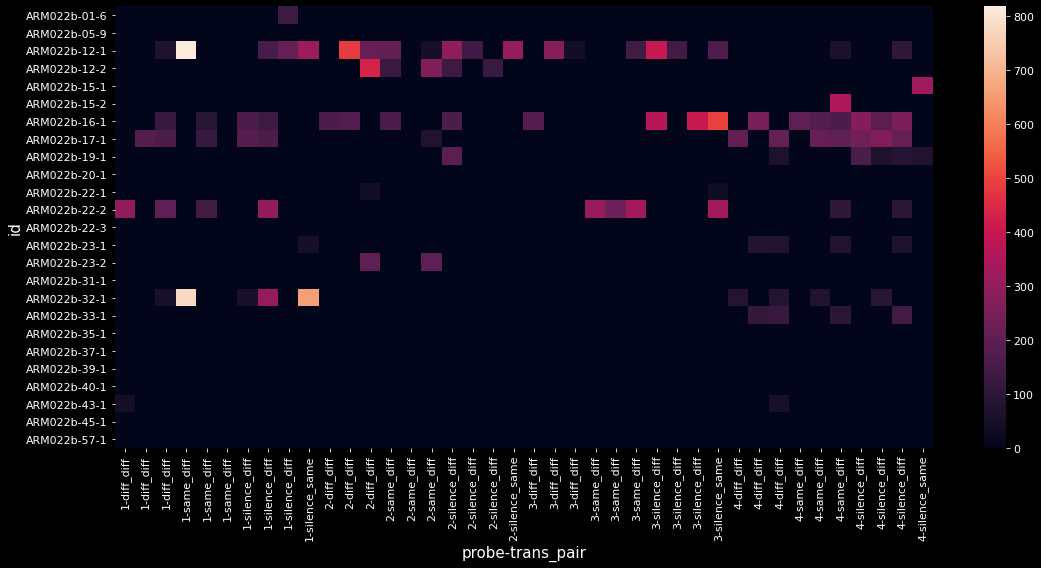

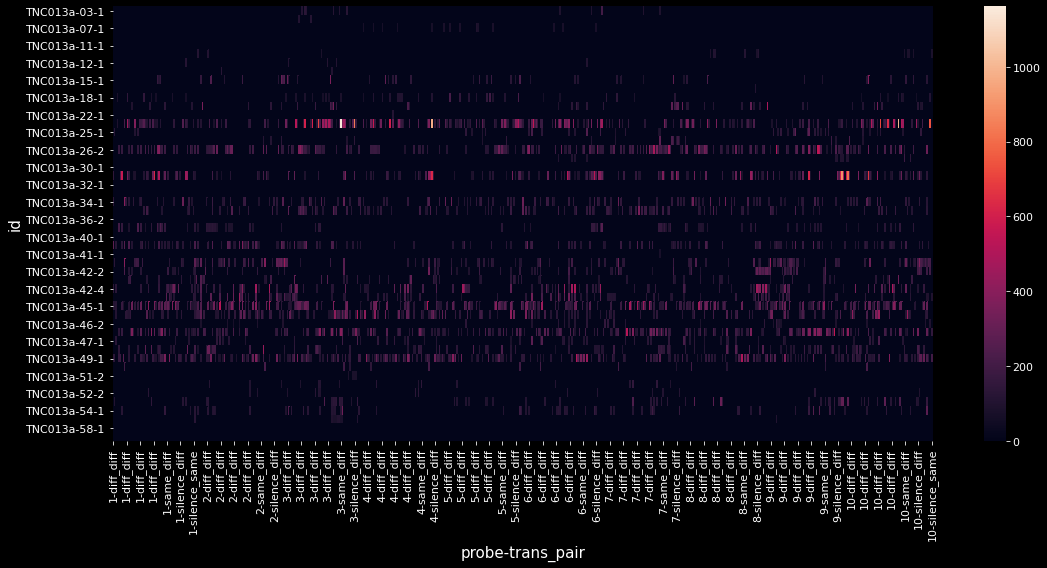

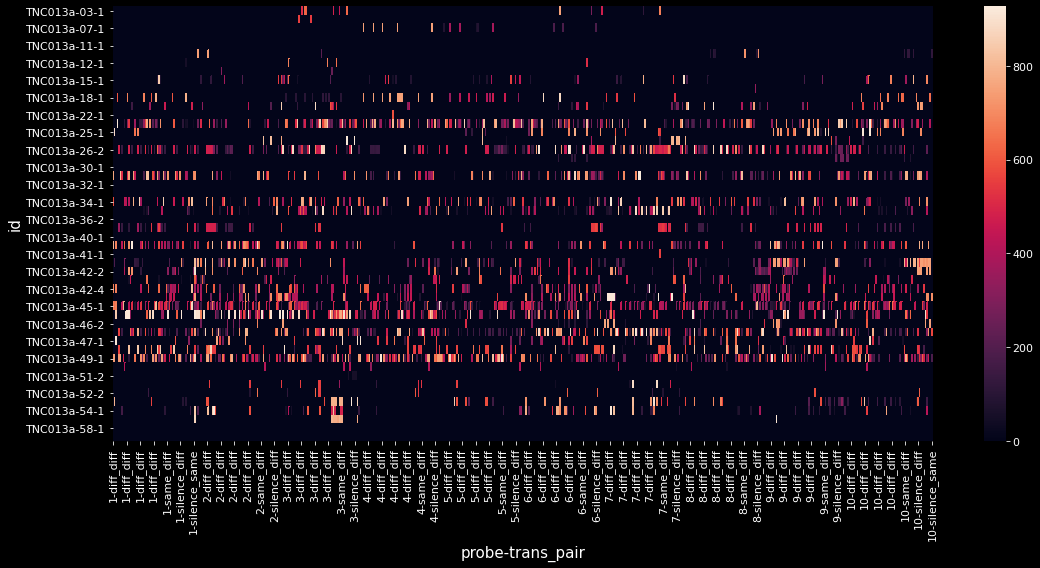

In [223]:
metrics = ["integral (d'*ms)", "center of mass (ms)"]
# sites = ['ARM021b', 'TNC014a'] # based on best cells
sites = ['ARM022b', 'TNC013a']# based on best sites

for site, metric in itt.product(sites, metrics):
    site_barcode = summary.loc[[site], [metric]]
    site_barcode = site_barcode.droplevel(level=0, axis=0).droplevel(level=[0,3], axis=1).dropna(axis=1, how='all')

    values = site_barcode.values
    n_signig = np.sum(values > 0)
    n_total = values.size
    signif_percent = n_signig / n_total * 100


    fig, ax = plt.subplots(figsize=(16,8))
    ax = sns.heatmap(data=site_barcode, xticklabels='auto', ax=ax)
    title = f'{site} {metric} barcode {signif_percent}prcent signif'
    savefig(fig, 'NGP_retreat', title)
plt.show()

In [ ]:
site_barcode.values

## stack of sites

saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/tiny ARM022b integral (d'*ms) barcode.png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/tiny ARM017a integral (d'*ms) barcode.png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/tiny ARM027a integral (d'*ms) barcode.png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/tiny ARM031a integral (d'*ms) barcode.png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/tiny ARM021b integral (d'*ms) barcode.png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/NGP_retreat/tiny ARM026b integral (d'*ms) barcode.png


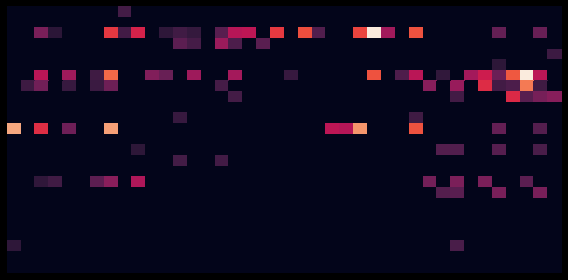

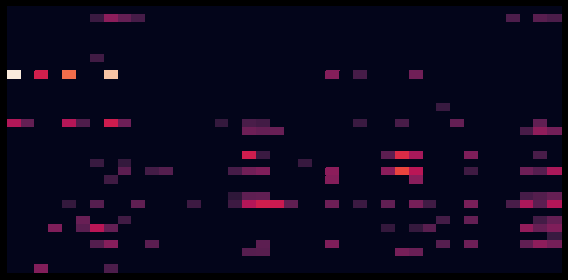

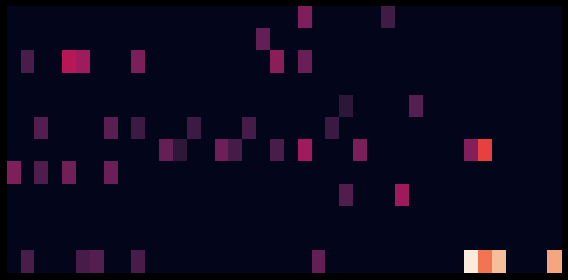

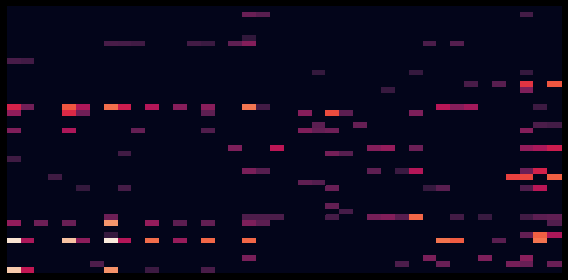

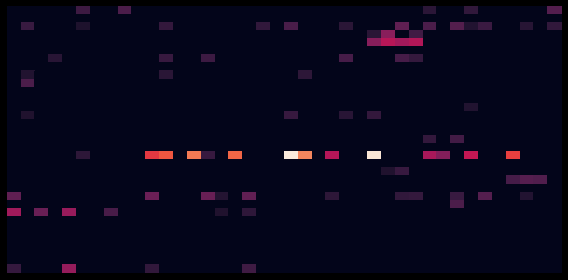

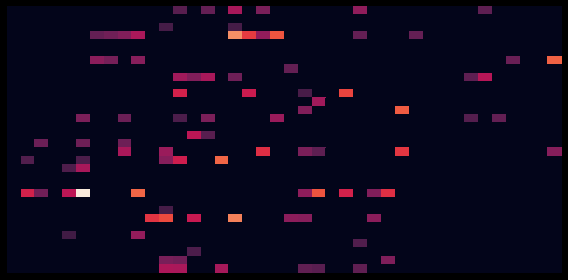

In [225]:
metrics = ["integral (d'*ms)",]
# sites = ['ARM021b', 'TNC014a'] # based on best cells
sites = ['ARM022b', 'ARM017a', 'ARM027a', 'ARM031a', 'ARM021b', 'ARM026b'] # based on best sites

for site, metric in itt.product(sites, metrics):
    site_barcode = summary.loc[[site], [metric]]
    site_barcode = site_barcode.droplevel(level=0, axis=0).droplevel(level=[0,3], axis=1).dropna(axis=1, how='all')
    fig, ax = plt.subplots(figsize=(8,4))
    ax = sns.heatmap(data=site_barcode, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    title = f'tiny {site} {metric} barcode'
    savefig(fig, 'NGP_retreat', title)
plt.show()

